# Creating Toy Datasets from Materials Project Systematically

## Download Element Data (to save time)

In [16]:
from mp_api.client import MPRester
from pathlib import Path
import json
import matplotlib.pyplot as plt
import numpy as np
from pymatgen.core import Element
path_data = Path("./data")
path_data.mkdir(exist_ok=True)
path_element_to_ids = path_data/"element_to_ids.json"
API_KEY = "YOUR_KEY_HERE"

In [17]:
element_strings = [str(Element.from_Z(i+1)) for i in range(118)] ; element_strings[:10]

['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne']

In [23]:
if not path_element_to_ids.exists():  
    element_to_ids = {}
    for element in element_strings:
        with MPRester(API_KEY) as mpr:
            docs = mpr.materials.summary.search(elements=[element], fields=["material_id"])       
        element_to_ids[element] = [doc.material_id.string for doc in docs]
    
    with open(path_element_to_ids, 'w') as f: 
        json.dump(element_to_ids, f)
else:
    with open(path_element_to_ids, 'r') as f: 
        element_to_ids = json.load(f)

Retrieving SummaryDoc documents:   0%|          | 0/10394 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/8 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/21686 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1175 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/6292 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/9022 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/11396 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/81825 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/12067 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/12823 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/18958 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/7689 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/12658 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/16828 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/15220 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/6373 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/8012 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/8439 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2682 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/7696 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/9742 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/6819 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/14018 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/12915 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/11038 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/8239 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/9784 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/6857 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/4983 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/5358 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/3886 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/6437 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/3012 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/15 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/4586 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/7291 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/4997 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/3840 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/5457 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/5380 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/694 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2414 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2446 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2894 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/4062 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/3337 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/4330 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/6122 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/5774 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/4947 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/3004 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/158 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/4050 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/8277 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/5619 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/3245 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2868 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/3218 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/525 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2882 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2444 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1647 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2214 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2305 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2155 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2193 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1742 [00:00<?, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1620 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2731 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/3394 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/5143 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1461 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1216 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2023 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2389 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2441 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2304 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2972 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2980 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/4922 [00:00<?, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/291 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1055 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/277 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2428 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/407 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/463 [00:00<?, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

In [27]:
counts = {element: len(ids) for element, ids in element_to_ids.items()}

## Element Distribution Analysis

In [48]:
def plot_bar(dict, ax=None):
    if not ax:
        fig, ax = plt.subplots()
    ax.bar(range(len(dict)), list(dict.values()), align='center')
    ax.set_xticks(range(len(dict)), list(dict.keys()))

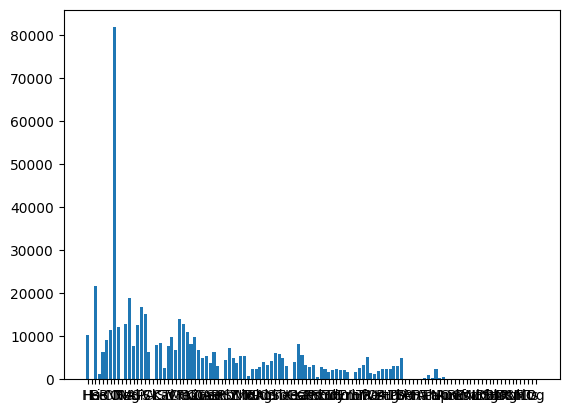

In [43]:
plot_bar(counts)

According to MP website 10,394 materials contain H; 8 He; 21,686 Li

In [5]:
with MPRester(API_KEY) as mpr:
    docs = mpr.materials.summary.search(
        elements=["H"], fields=["material_id", "formula_pretty"]
    )
    mpid_formula_dict = {
        doc.material_id: doc.formula_pretty for doc in docs
    }

Retrieving SummaryDoc documents:   0%|          | 0/10394 [00:00<?, ?it/s]

In [6]:
len(docs)

10394

In [7]:
element = 9
for id in materials_by_element[element]:
    if not (element in mp_elements[id]):
        print(mp_elements[id].elements)

In [8]:
h_ids = [id.string for id in mpid_formula_dict.keys()]

In [9]:
[id for id in materials_by_element[1] if not (id in h_ids)]

['mp-697915',
 'mp-1187975',
 'mp-632667',
 'mp-634930',
 'mp-634751',
 'mp-864603',
 'mp-625103',
 'mp-626421',
 'mp-632348',
 'mp-1070852',
 'mp-2646948',
 'mp-1025273',
 'mp-1103732',
 'mp-626413',
 'mp-643108',
 'mp-1207586',
 'mp-740759',
 'mp-1206323',
 'mp-1018646',
 'mp-1018647',
 'mp-1187892',
 'mp-1207571',
 'mp-1207559',
 'mp-979964',
 'mp-1195507',
 'mp-1198634',
 'mp-1105386',
 'mp-1216487',
 'mp-643246',
 'mp-1195012',
 'mp-1195544',
 'mp-643071',
 'mp-1203501',
 'mp-1202946',
 'mp-1200022',
 'mp-705525',
 'mp-555985',
 'mp-1202633',
 'mp-1202882',
 'mp-1198247',
 'mp-1238179',
 'mp-1200794',
 'mp-1191250',
 'mp-697925',
 'mp-699393',
 'mp-1212344',
 'mp-722346',
 'mp-1203140',
 'mp-1200555',
 'mp-1202119',
 'mp-1193866',
 'mp-1190437',
 'mp-1198865',
 'mp-1200481',
 'mp-1200272']

In [10]:
"mp-697915"

'mp-697915'

In [11]:
len([id for id in materials_by_element[1] if not (id in h_ids)])

55

In [12]:
with MPRester(API_KEY) as mpr:
    docs = mpr.materials.summary.search(
        material_ids=[id for id in materials_by_element[1] if not (id in h_ids)]
    )

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

## Let's get a Dataset with the First Two Rows of Period Table
Let's get the "target" distribution

In [44]:
selected_elements = [str(Element.from_Z(i+1)) for i in range(18)] # to Argon

In [45]:
selected_counts = {element: count for element, count in counts.items() if element in selected_elements}

In [57]:
num_materials = 10000
max_samples = num_materials // len(selected_elements)

In [58]:
targets = {element: min(max_samples, selected_counts[element]) for element in selected_elements}

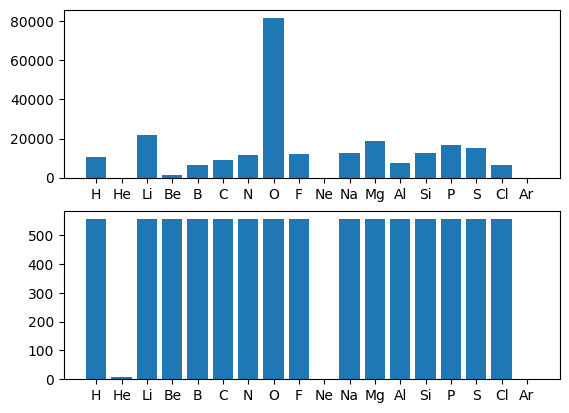

In [59]:
fig, ax = plt.subplots(2)
plot_bar(selected_counts, ax[0])
plot_bar(targets, ax[1])

In [60]:
samples = {
    element: np.random.choice(element_to_ids[element], size=targets[element])
    for element in selected_elements
          }